<a href="https://colab.research.google.com/github/Abhay818/RL/blob/main/Rl_Practical4_Baby_Robot_(part2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import numpy as np

In [67]:
class PowerSocket:
    """ the base power socket class """

    def __init__(self, q):
        self.q = q        # the true reward value
        self.initialize() # reset the socket

    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value
        self.n = 0   # the number of times this socket has been tried

    def charge(self):
        """ return a random amount of charge """

        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q

        # never allow a charge less than 0 to be returned
        return 0 if value < 0 else value

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def sample(self):
        """ return an estimate of the socket's reward value """
        return self.Q


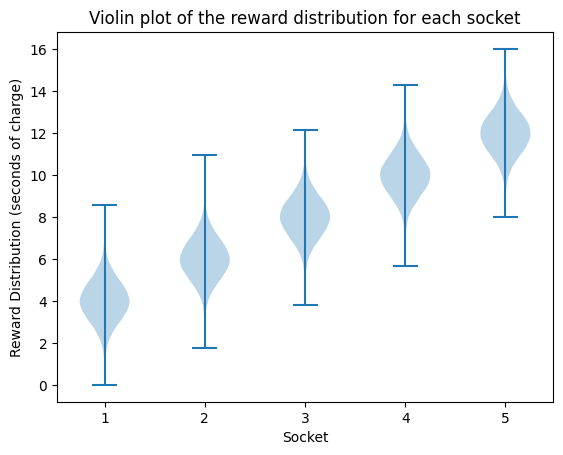

In [68]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize

# create 5 sockets in a fixed order
socket_order = [1,2,3,4,5]

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*2)+2) for q in socket_order]

# save the number of sockets
NUM_SOCKETS = len(socket_order)

# using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

# rewards will contain the charge returned at all of the time steps for each socket
rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))

# iterate through each of the sockets
for socket_number,socket in enumerate(sockets):

    # get charge from the socket for the defined number of steps
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()

#With the sockets set up in this way we get the following output from each of the sockets:

# plot the charge we got from the sockets
plt.violinplot(rewards)
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)')
plt.title('Violin plot of the reward distribution for each socket')
plt.show()


<ipython-input-69-a3ccf810f705>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-69-a3ccf810f705>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
sim

Text(0, 0.5, 'Density')

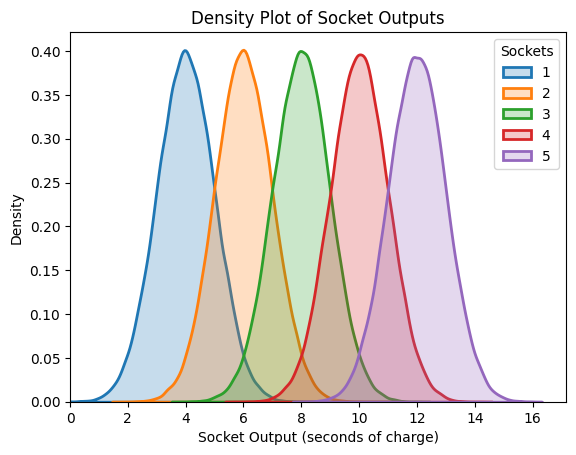

In [69]:
# iterate through the sockets to draw each plot
# (from: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0)
for socket_number in range(NUM_SOCKETS):
    sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = f'{socket_number+1}');

# Plot formatting
plt.xlim(0, None)
plt.legend(title = 'Sockets')
plt.title('Density Plot of Socket Outputs')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')




In [70]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket=PowerSocket, socket_order=socket_order, multiplier=2, **kwargs ):

        # create supplied socket type with a mean value defined by socket order
        self.sockets = [socket((q*multiplier)+2, **kwargs) for q in socket_order]

    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """

        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

    def select_socket( self, t ):
        """ choose the socket with the current highest mean reward or arbitrarily
            select a socket in the case of a tie """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
        return socket_index


    def run( self, number_of_steps, maximum_total_reward = float('inf')):
        """ perform a single run for the defined number of steps """

        for t in range(number_of_steps):
            # select a socket
            socket_index = self.select_socket(t)

            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)


In [71]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))


In [72]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)

from PowerSocketSystem import *


In [73]:
# Create an Optimistic Socket class by inheriting from the standard Power Socket
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):

        # get the initial estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.)

        # pass the true reward value to the base PowerSocket
        super().__init__(q)


    def initialize(self):
        # estimate of this socket's reward value
        # - set to supplied initial value
        self.Q = self.initial_estimate

        # the number of times this socket has been tried
        # - set to 1 if an initialisation value is supplied
        self.n = 1 if self.initial_estimate  > 0 else 0


In [74]:
# highlight the maximum value on a row
def highlight_max_row_value( row ):
    '''
    highlight the maximum value on the supplied row
    '''
    is_max = row == row.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_change_in_column( col ):
    '''
    highlight the entry before the column value changes
    '''
    style = []
    for i in range(col.shape[0]):
        if i < (col.shape[0]-1) and col.iloc[i] != col.iloc[i+1]:
            style.append('background-color: yellow')
        else:
            style.append('')
    return style


In [75]:
tester = SocketTester( OptimisticSocket, initial_estimate = 20.)
tester.run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage():0.3f}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')


Mean Reward per Time Step = 11.153134566363024
Optimal Socket Selected = 0.724
Socket Percentages = [0.069 0.069 0.103 0.724 0.207]


In [76]:
# convert to a Pandas dataframe for table display & rename the columns to be 1-based
estimates = tester.socket_stats[:,:,0]
df = pd.DataFrame(estimates[:10])
df.columns = [1,2,3,4,5]


In [77]:
# show the estimates of each socket, highlighting the socket that has been selected for each time step
# - truncating to the first 20 time steps for clarity
df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=df.index[-1])


,1,2,3,4,5
0,20.000000,20.000000,20.000000,20.000000,20.000000
1,20.000000,11.816561,20.000000,20.000000,20.000000
2,20.000000,11.816561,20.000000,15.934397,20.000000
3,20.000000,11.816561,20.000000,15.934397,15.448865
4,12.087901,11.816561,20.000000,15.934397,15.448865
5,12.087901,11.816561,13.621893,15.934397,15.448865
6,12.087901,11.816561,13.621893,14.069250,15.448865
7,12.087901,11.816561,13.621893,14.069250,13.919635
8,12.087901,11.816561,13.621893,13.701798,13.919635
9,12.087901,11.816561,13.621893,13.701798,13.248980


Text(0, 0.5, 'Socket Reward Estimate')

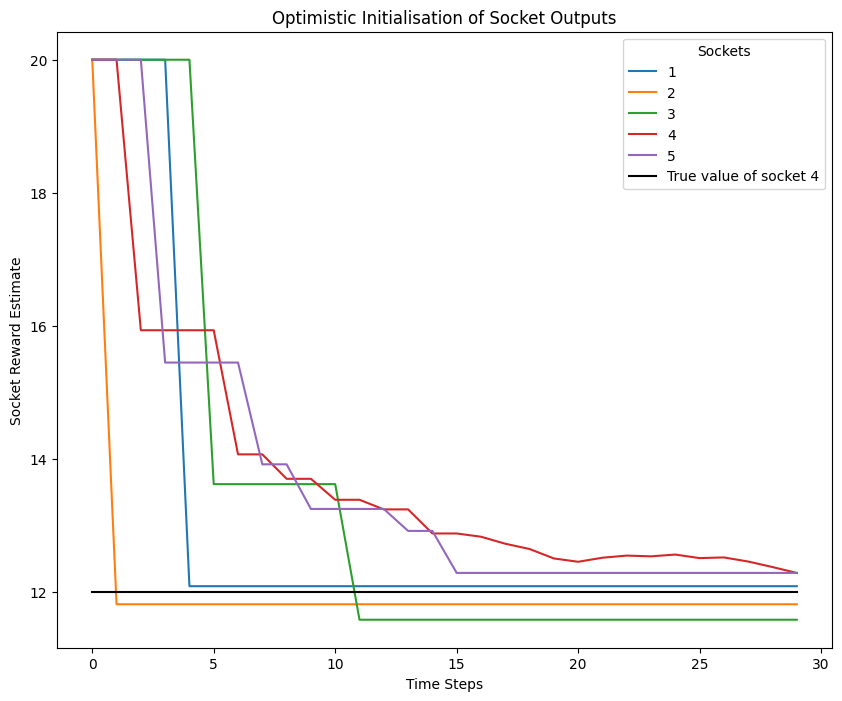

In [78]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:30,socket], label = f'{socket+1}')

plt.plot(np.ones(30)*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')


In [79]:
def plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(10,8) ):

    plt.figure(figsize=figsize)
    plt.plot( initial_values, reward, marker='o', linestyle='--', color='r')

    # draw reference lines
    plt.plot(np.ones(max_initial_value+1)*np.max(socket_means),'k', label = f'Maximum Socket Reward')
    plt.plot(np.ones(max_initial_value+1)*np.mean(socket_means),'b', label = f'Mean Socket Reward')

    plt.legend(title = 'Key:')
    plt.title('Optimistic Initialisation: Mean Total Reward vs Initial Values')
    plt.xlabel('Initial Values')
    plt.ylabel('Mean Total Reward')


In [80]:
def run_initialisation_experiment( start, end, step = 1 ):
    """ test varying the initial estimate for optimistic-greedy """

    number_of_tests = 1000
    number_of_steps = 30
    number_of_sockets = len(socket_order)

    reward = []
    optimal_selected = []
    socket_percentages = []
    initial_values = []

    # iterate over the initial estimate values
    for initial_estimate in tqdm(range( start, (end+step), step )):

        initial_values.append( initial_estimate )

        socket_tester = SocketTester( OptimisticSocket, socket_order, initial_estimate = initial_estimate)

        socket_experiment = SocketExperiment(socket_tester = socket_tester,
                                             number_of_tests = number_of_tests,
                                             number_of_steps = number_of_steps)
        socket_experiment.run()

        reward.append( socket_experiment.get_mean_total_reward() )
        optimal_selected.append( socket_experiment.get_optimal_selected() )
        socket_percentages.append( socket_experiment.get_socket_percentages() )

    return initial_values, reward, optimal_selected, socket_percentages


100%|██████████| 11/11 [00:08<00:00,  1.24it/s]


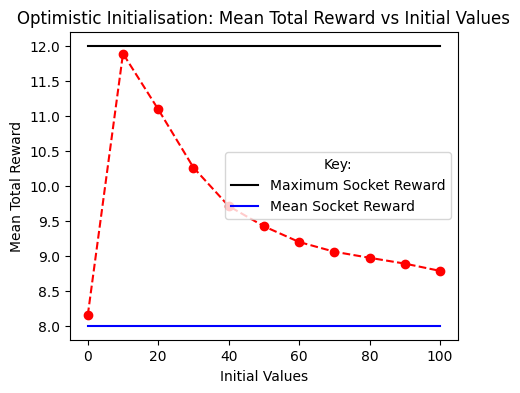

In [81]:
max_initial_value = 100
step = 10
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )
plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(5,4) )



Text(0, 0.5, 'Socket Selection (%)')

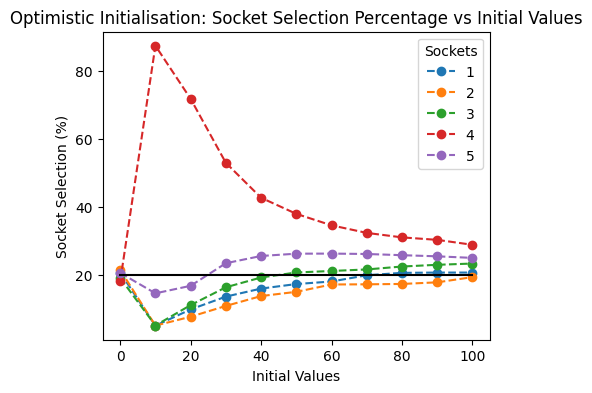

In [82]:
df = pd.DataFrame(socket_percentages)

plt.figure(figsize=(5,4))

for socket in range(df.shape[1]):
    plt.plot(initial_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')

plt.plot(initial_values, np.ones(df.shape[0])*20,'k')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation: Socket Selection Percentage vs Initial Values')
plt.xlabel('Initial Values')
plt.ylabel('Socket Selection (%)')


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


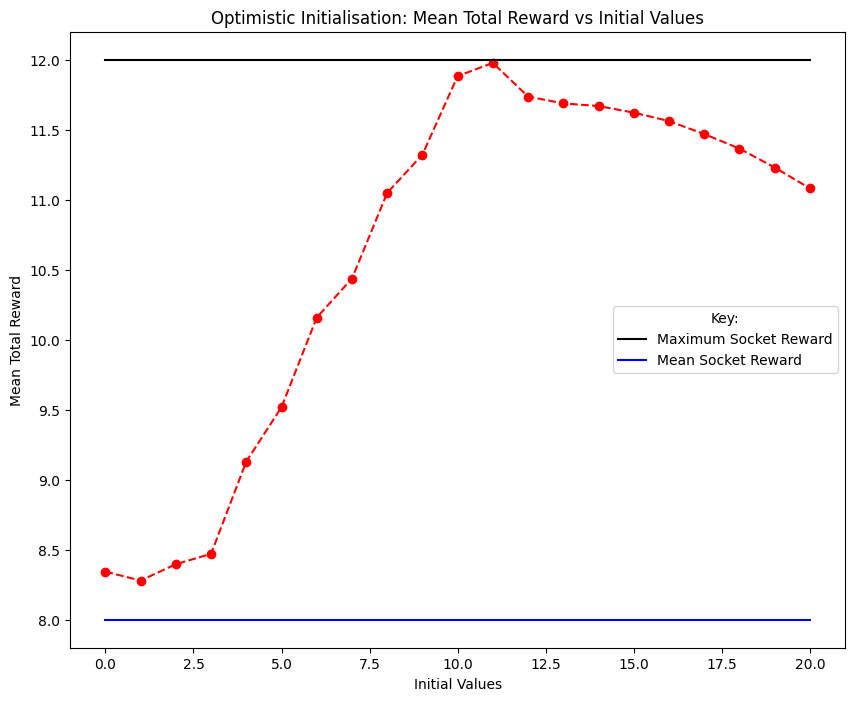

In [83]:
max_initial_value = 20
step = 1
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )
plot_initial_optimisation( initial_values, reward, max_initial_value )


In [84]:
class EpsilonGreedySocketTester( SocketTester ):

    def __init__(self, epsilon = 0. ):

        # create a standard socket tester
        super().__init__()

        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon


    def select_socket( self, t ):
        """ Epsilon-Greedy Socket Selection"""

        # probability of selecting a random socket
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < self.epsilon:
            socket_index = np.random.choice(self.number_of_sockets)
        else:
            # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie
            socket_index = random_argmax([socket.sample(t) for socket in self.sockets])

        return socket_index


In [85]:
# create and test epsilon-greedy sockets
tester = EpsilonGreedySocketTester( epsilon = 0.1 )
tester.run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage()}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')



Mean Reward per Time Step = 11.626732494181274
Optimal Socket Selected = 0.91991991991992
Socket Percentages = [0.022 0.020 0.020 0.920 0.018]


In [86]:
def plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')

    plt.plot(epsilon_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Socket Selection (%)')

def plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps ):
    df = pd.DataFrame(final_socket_estimates)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket], label = f'{socket+1}', marker='o', linestyle='--')

    plt.legend(title = 'Sockets')
    plt.title('Final Socket Estimate vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Final Socket Estimate')

def plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):

    plt.plot( epsilon_values, reward_per_timestep, marker='o', linestyle='--', color='r')
    plt.title('Mean Total Reward per Time Step vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Mean Total Reward per Time Step')


def plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(26,5))

    plt.suptitle(f'Epsilon Greedy: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 3, 1)
    plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps )

    plt.subplot(1, 3, 2)
    plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps )

    plt.subplot(1, 3, 3)
    plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps )

    plt.show()


In [87]:
def epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon = 0.):

    experiment = SocketExperiment(socket_tester   = EpsilonGreedySocketTester( epsilon ),
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps)
    experiment.run()

    return experiment.get_estimates(),\
           experiment.get_mean_total_reward(),\
           experiment.get_optimal_selected(),\
           experiment.get_socket_percentages()


In [88]:
def run_epsilon_greedy_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):

    test_values = []
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    final_socket_estimates = []

    # iterate over the epsilon values
    for epsilon in tqdm( np.arange( start, (end+step), step ) ):

        # save the test value used to run this test
        test_values.append( epsilon )

        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon )

        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage )
        final_socket_estimates.append( mean_estimates[-1] )

    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates


100%|██████████| 21/21 [00:31<00:00,  1.50s/it]


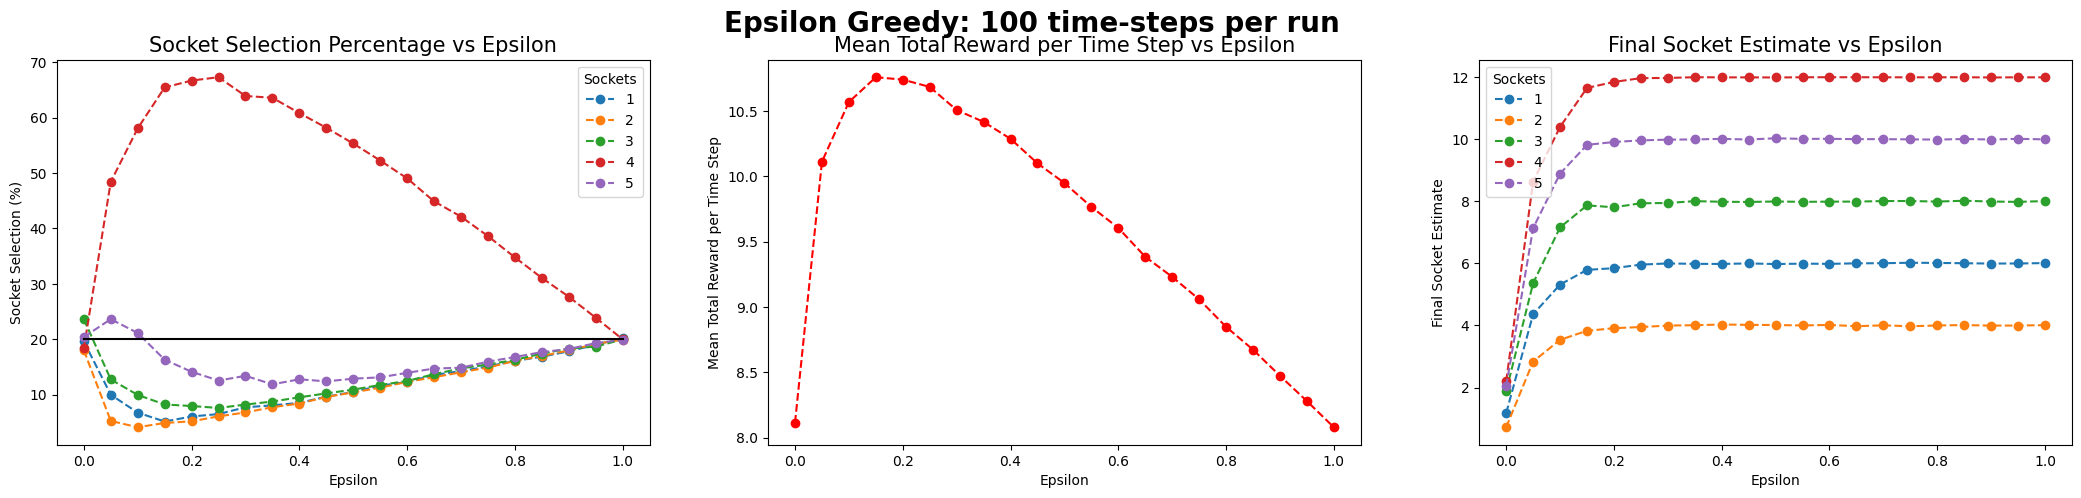

In [89]:
# how many times each test should be run
number_of_tests = 500

# the epsilon test range
start = 0
stop = 1.0
step = 0.05

number_of_steps = 100
epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_epsilon_greedy_experiment( start, stop, step, number_of_tests, number_of_steps )

plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps )


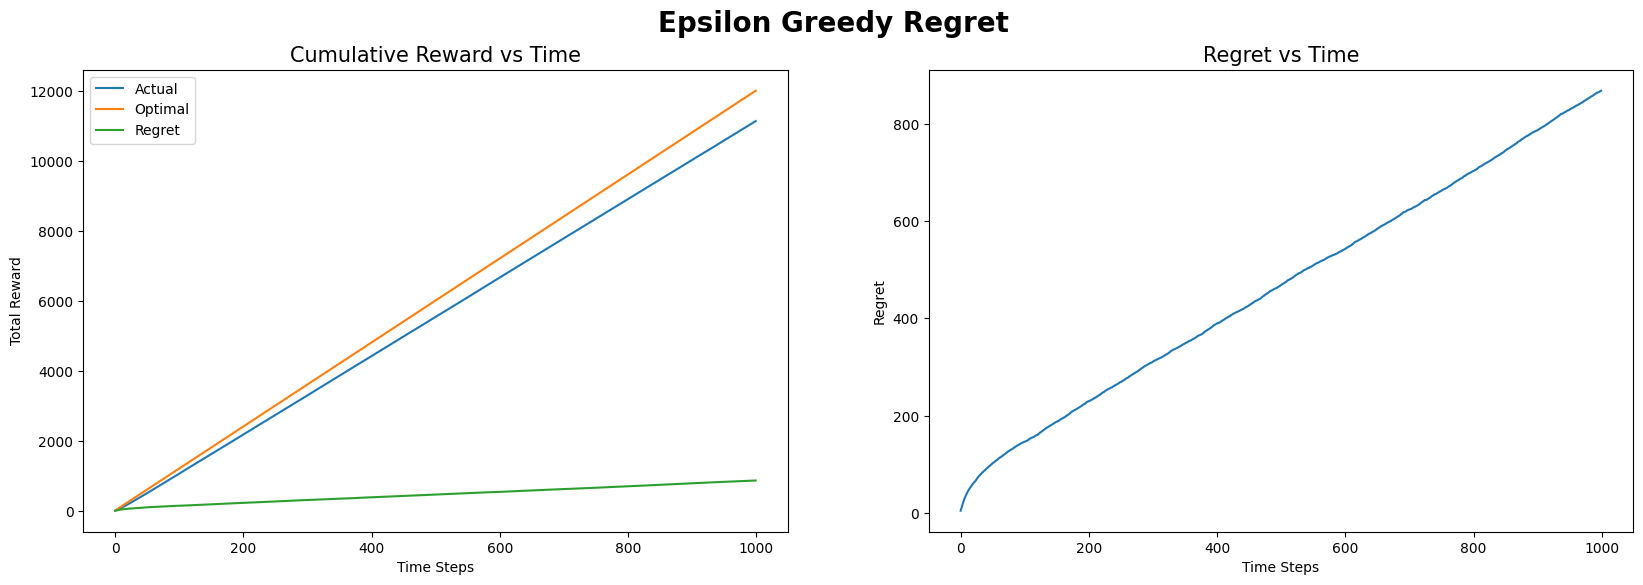

In [90]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 100
number_of_steps = 1000
epsilon = 0.2

experiment = SocketExperiment(socket_tester   = EpsilonGreedySocketTester( epsilon ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()


# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Epsilon Greedy Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.show()
